In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torch.optim.lr_scheduler as lr_scheduler
# from torch.optim.lr_scheduler import _LRScheduler
# import torch.utils.data as data
import numpy as np
np.set_printoptions(suppress=True)
# import openslide as ops

# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# import torchvision.models as models
import pydot
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from fastprogress import progress_bar
import copy
from collections import namedtuple
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import random
import shutil
import time
from PIL import Image,ImageDraw,ImageEnhance,ImageColor 
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_efficientnet_v2
import cv2
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# #from tensorflow import ConfigProto
# #from tensorflow import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

Image.MAX_IMAGE_PIXELS = 10000000000
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
def timebase_get_file_list(file_path):
    dir_list = os.listdir(file_path)
    if not dir_list:
        return
    else:
        dir_list = sorted(dir_list,key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
        return dir_list
def namebase_get_file_list(file_path):
    dir_list = os.listdir(file_path)
    if not dir_list:
        return
    else:
        dir_list = sorted(dir_list)
        return dir_list

def detection_3d(model1,test_img):

    timg = Image.fromarray((test_img))
    timg1 = np.array(timg)
    
    testarray = [[] for i in range(4)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
    testarray[2] = np.rollaxis(timg1,0,2)
    testarray[3] = (np.rot90(timg1,2))
    
    testarray = np.asarray(testarray)
    
    aa = modeleva_3d(model1,testarray)
#     bb= aa[0]
#     bb[0] = np.average(aa[...,0])
#     bb[1] = np.average(aa[...,1])
#     bb[2] = np.average(aa[...,2])
#     bb[3] = np.average(aa[...,3])
#     return aa
    return np.average(aa[:,0]),np.average(aa[:,1])
#     return np.average(aa)

def modeleva_3d(model,test_img):
    test_img = np.asarray(test_img,dtype= np.float32)/255
    return model.predict(test_img)

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus


In [4]:
model_path = 'EfficientNetV2L_bad1' #Xception
model_id = 50

all_patch_list = namebase_get_file_list('./result/' + str(model_path))
model_name = [s for s in np.asarray(all_patch_list) if (str(model_id)+'-') in s][0]
model = keras.models.load_model('./result/' + str(model_path) + '/' + model_name)

if(os.path.isdir('./result/' + str(model_path) + '/cam_' + str(model_id) + '/') == False):
    os.mkdir('./result/' + str(model_path) + '/cam_' + str(model_id) + '/')
    
data_array = np.load('./train/test/data_array.npy',allow_pickle=True)

In [5]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [6]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 0, 0, 0])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][0], output[1][0], output[2][0], output[3][0])

In [7]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    gc.collect() # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

def gradcam_3d(model1,test_img):

    timg1 = np.asarray(test_img)
    
    images = np.asarray([np.array(timg1), np.array(np.flip(timg1,0)), np.array(np.rollaxis(timg1,0,2)), np.array((np.rot90(timg1,2)))])

    X = images/255

    gradcam = Gradcam(model1,
                      model_modifier=replace2linear,
                      clone=True)

    # Generate heatmap with GradCAM
    cam = gradcam(score,
                  X,
                  penultimate_layer=-1)
    
    aa = copy.deepcopy((images)*0.)       
    aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
    aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
    aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)
    
    temp_cam_all = aa[0] + aa[1] + aa[2]  + aa[3]
    return temp_cam_all
    
    
    

In [ ]:
patch_size = 256
overlap = 128

reset_keras()
clean = 1
for types,mask_id in progress_bar([(1,1),(1,3),(1,4),(4,1),(4,2),(4,3),(4,4),(4,5),(7,4),(7,5)]):

# for types in [1]:
#     for mask_id in range(1,2):
        
        if(os.path.exists(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'.svs')==True):
            
#             tif = ops.open_slide(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'.svs')

            god_img_mask = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_good.png')))
            god_img_mask = cv2.resize(god_img_mask, (god_img_mask.shape[1]//2,god_img_mask.shape[0]//2),interpolation = cv2.INTER_AREA    )
    
#             bad_img_mask = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_bad.png')))
#             bad_img_mask = cv2.resize(bad_img_mask, (god_img_mask.shape[1],god_img_mask.shape[0]),interpolation = cv2.INTER_AREA    )
            
            gradcam_mask = np.zeros((god_img_mask.shape[0],god_img_mask.shape[1],3), dtype = np.float64)
            sub_mask    = copy.deepcopy(np.asarray(god_img_mask*0, dtype = np.uint8))
            
            
#             total_size = bad_img_mask.shape[1],bad_img_mask.shape[0]
            
            for temp_patch in progress_bar(data_array[types][mask_id]):
                test_img = temp_patch[2]
                x = temp_patch[0]//2
                y = temp_patch[1]//2
                
                cam_result = gradcam_3d(model, test_img)
                
                clean+=1
                if(clean==5):
                    reset_keras()
                    clean = 0
                
                gradcam_mask[y:y+patch_size,x:x+patch_size] += cam_result
                sub_mask[y:y+patch_size,x:x+patch_size] += 1
                            
            gradcam_mask2 = copy.deepcopy(gradcam_mask)
            sub_mask[sub_mask==0] = 1
            gradcam_mask2 = gradcam_mask2/(np.stack([sub_mask,sub_mask,sub_mask],2))
            
            np.save('./result/' + str(model_path) + '/cam_' + str(model_id) + '/' + str(types) + '_' + str(mask_id),  gradcam_mask2)
               

'./result/vgg16_bad2/cam_50/1_1'

In [69]:
gradcam_mask2 = copy.deepcopy(gradcam_mask)

sub_mask[sub_mask==0] = 1

gradcam_mask2 = gradcam_mask2/(np.stack([sub_mask,sub_mask,sub_mask],2))

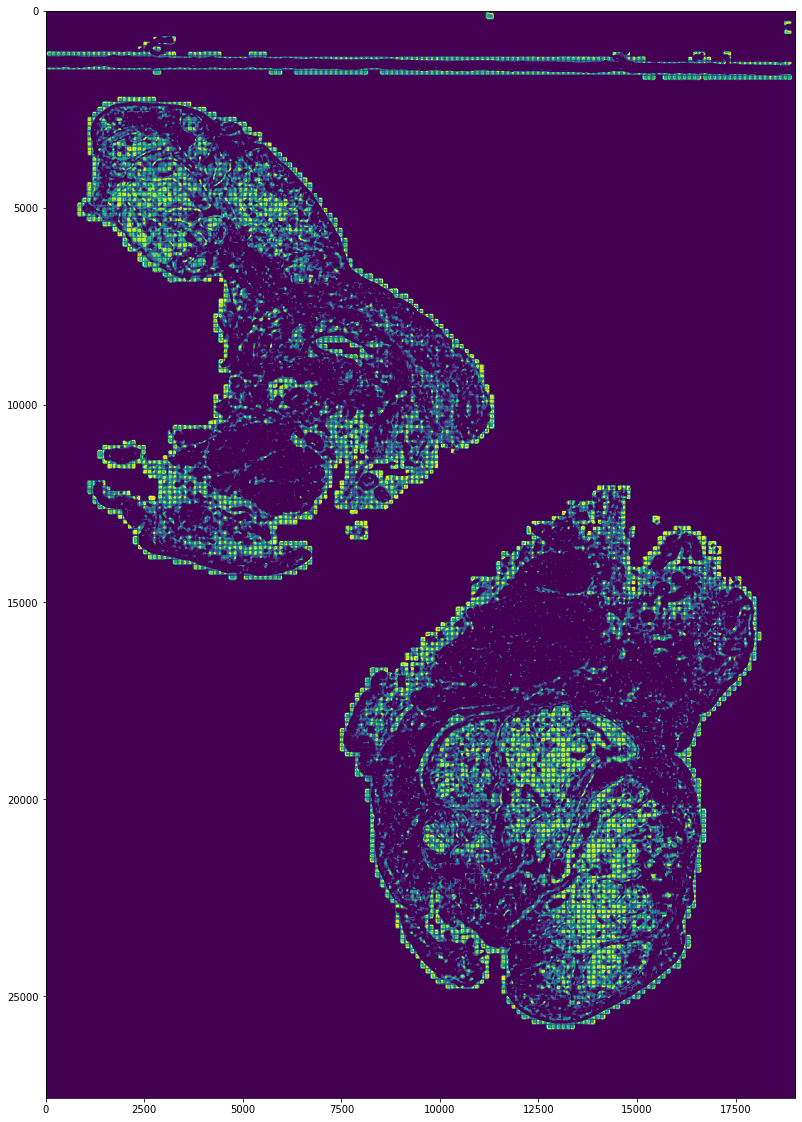

In [71]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2[...,0], interpolation='nearest')
plt.show()

In [ ]:
np.save('./result/vgg16_bad1_50_' + str(types) + '_' + str(mask_id),  gradcam_mask2)

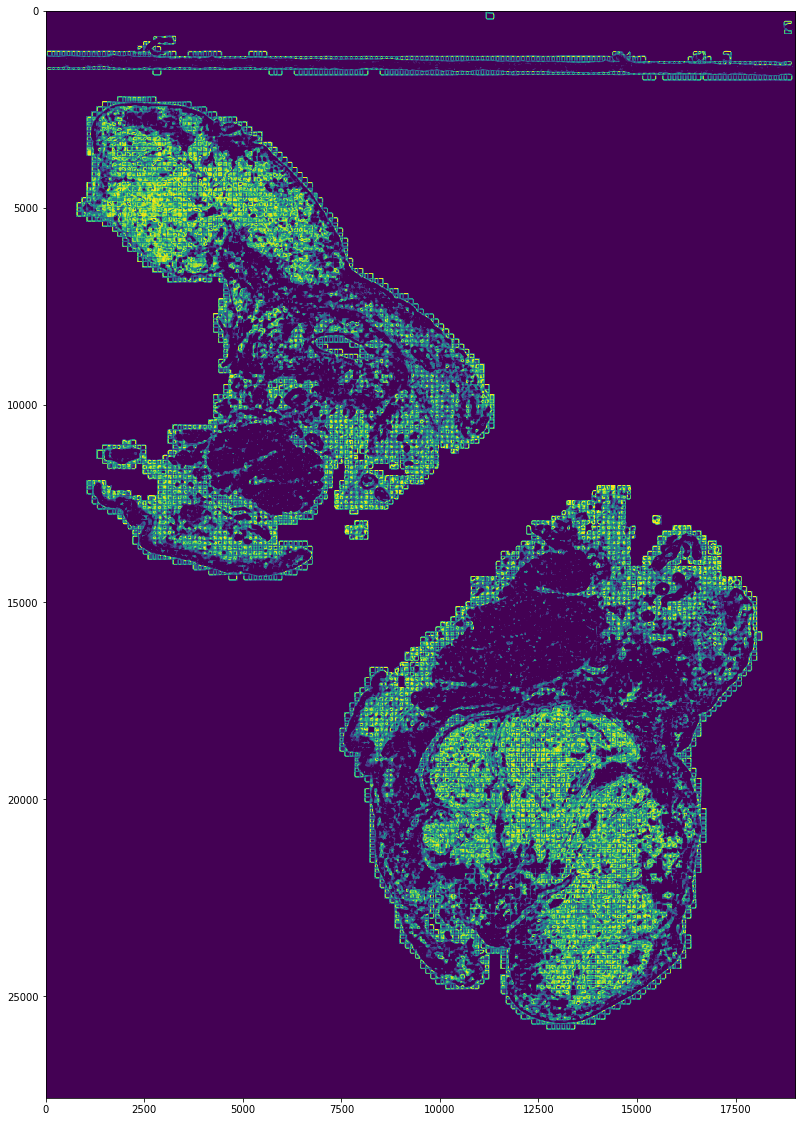

In [72]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2[...,1], interpolation='nearest')
plt.show()

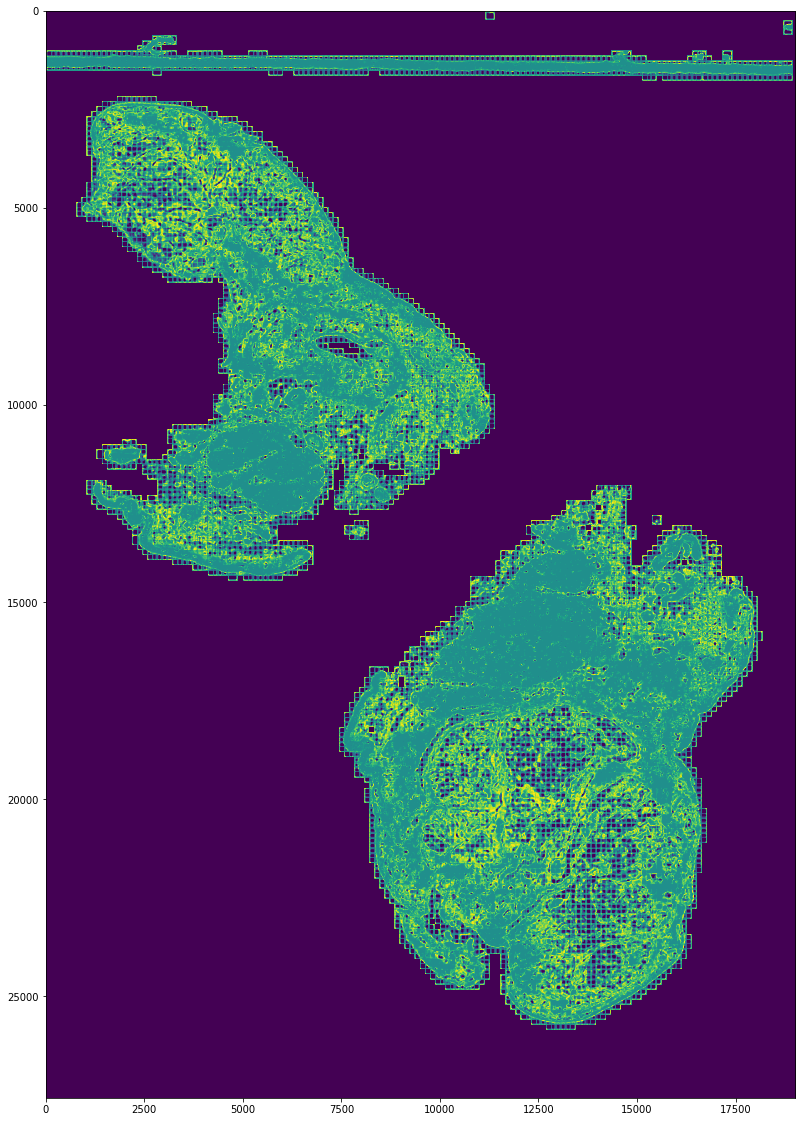

In [73]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2[...,2], interpolation='nearest')
plt.show()

In [48]:
god_img_mask2 = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_good.png')))

In [50]:
god_img_mask.shape

(19018, 27579)

In [55]:
god_img_mask2.shape

(55158, 38037)

In [45]:
gradcam_mask.shape


(19018, 27579, 3)

In [46]:
[y,y+patch_size,x,x+patch_size]

[18816, 19072, 7808, 8064]

In [34]:
gradcam_mask[y:y+patch_size,x:x+patch_size].shape

(0, 256, 3)

In [24]:
import keras

In [79]:
from tf_keras_vis.gradcam import Gradcam


In [40]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
    
    gc.collect()
#     print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [108]:
tf.keras.backend.clear_session()

In [ ]:
# del model
model = keras.models.load_model('./result/vgg16_bad1/50-0.13.h5')

In [103]:
from keras import backend as K
K.clear_session()

In [41]:
reset_keras()

In [25]:
i

10

In [ ]:
for i in range(0,50):
    cam_result = copy.deepcopy(gradcam_3d(model, img3))

In [16]:
def evaluate():
    for i in range(0,5):
        cam_result = copy.deepcopy(gradcam_3d(model, img3))
    print(i)

In [ ]:
cam_result

In [22]:
import multiprocessing

process_eval = multiprocessing.Process(target=evaluate, args=())
process_eval.start()
process_eval.join()

In [55]:
gradcam_mask[y:y+patch_size,x:x+patch_size].shape

(512, 512, 3)

In [ ]:
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

cam = scorecam(score, X, penultimate_layer=-1)

heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

In [27]:
X.shape

(3, 256, 256, 3)

In [47]:
temp_cam = gradcam_3d(model, img3)

In [51]:
temp_cam.shape

(256, 256, 3)

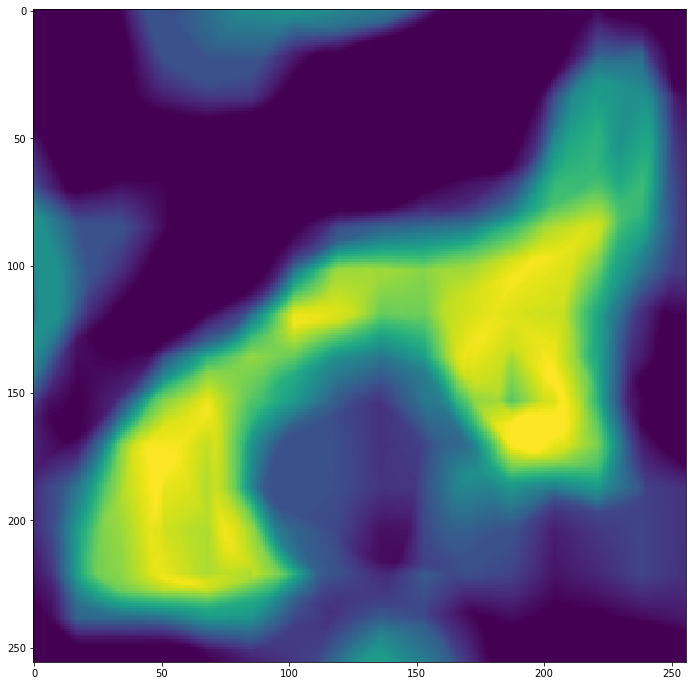

In [49]:
plt.figure(figsize=(12,12))
plt.imshow(temp_cam[...,0], interpolation='nearest')
plt.show()
# imshow(temp_cam_all[...,2], cmap='jet', alpha=1)

# plt.show()

TypeError: 'AxesSubplot' object does not support indexing

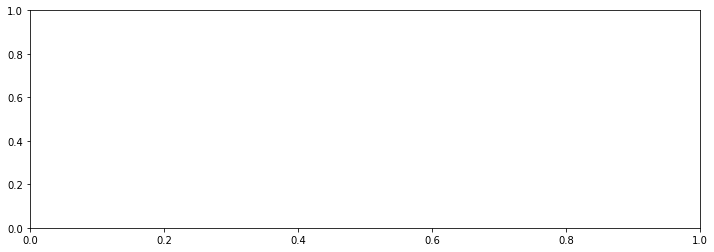

In [37]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
#     ax[i].imshow(images[i])
    ax[i].imshow(temp_cam_all[...,2], cmap='jet', alpha=1)
    ax[i].axis('off')
plt.tight_layout()
plt.show()


In [30]:
temp_cam[1][...,2]

array([[127., 127., 127., ..., 232., 227., 218.],
       [127., 127., 127., ..., 236., 227., 218.],
       [127., 127., 127., ..., 236., 227., 218.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [31]:
timg1 = np.asarray(img1)

#     images = np.asarray([np.array(img1), np.array(np.flip(timg1,0)), np.array(np.rollaxis(timg1,0,2)), np.array(np.rot90(timg1,2))])

#     images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
#     X = preprocess_input(images)

testarray = np.zeros((4, timg1.shape[0], timg1.shape[1], timg1.shape[2]) ,dtype=np.uint8)
testarray[0] = timg1 #原图
testarray[1] = (np.flip(timg1,0))
testarray[2] = np.rollaxis(timg1,0,2)
testarray[3] = (np.rot90(timg1,2))

X = np.asarray(testarray)
#     print(testarray.shape)

#     X = preprocess_input(images)
#     print(X.shape)



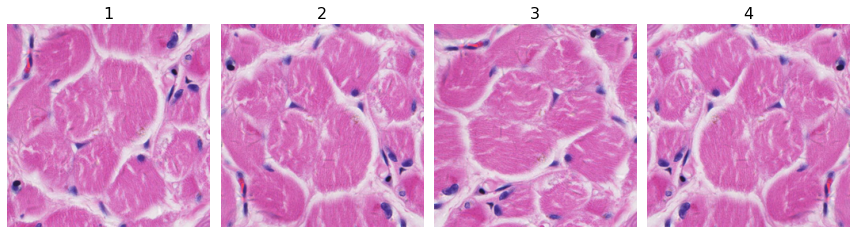

In [37]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [38]:
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
# aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
# aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
# aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)

In [56]:
def detection_3d(model1,timg1,m,temp_channel =1 ):

#     timg = Image.fromarray((test_img))
#     timg1 = np.array(timg)
    
    testarray = [[] for i in range(4)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
    testarray[2] = np.rollaxis(timg1,0,2)
    testarray[3] = (np.rot90(timg1,2))
    
    
    testarray = np.asarray(testarray)
#     print(testarray.shape)
    
#     aa = modeleva_3d(model1,testarray)
#     aa[aa>th] = 125
#     aa[aa!=125] = 0

#     aa = np.asarray(np.transpose(aa,(0,2,3,1)).reshape(aa.shape[0],aa.shape[2],aa.shape[3],3))
    aa = np.zeros((4), dtype = np.object)
    
    aa[0] = modeleva_3d(model1,testarray[0],temp_channel) + m
    aa[1] = np.flip((modeleva_3d(model1,testarray[1],temp_channel)),0)   + m
    aa[2] = np.rollaxis(modeleva_3d(model1,testarray[2],temp_channel),0,2) + m
    aa[3] = np.rot90((modeleva_3d(model1,testarray[3],temp_channel)),2) + m
    
    aa = aa[0] + aa[1] + aa[2] + aa[3]
    aa = aa/4
    
    return aa

In [11]:
gradcam_3d(model, img1)

NameError: name 'preprocess_input' is not defined

In [55]:
def detection_3d(model1,timg1,m):

#     timg = Image.fromarray((test_img))
#     timg1 = np.array(timg)
    
    testarray = [[] for i in range(2)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
#     testarray[2] = np.rollaxis(timg1,0,2)
#     testarray[3] = (np.rot90(timg1,2))
    
    testarray = np.asarray(testarray)
#     print(testarray.shape)
    
#     aa = modeleva_3d(model1,testarray)
#     aa[aa>th] = 125
#     aa[aa!=125] = 0

#     aa = np.asarray(np.transpose(aa,(0,2,3,1)).reshape(aa.shape[0],aa.shape[2],aa.shape[3],3))
    aa = np.zeros((2), dtype = np.object)
    
    aa[0] = modeleva_3d(model1,testarray[0],opchannel-1) + m
    aa[1] = np.flip((modeleva_3d(model1,testarray[1],opchannel-1)),0)   + m
#     aa[2] = np.rollaxis(modeleva_3d(model1,testarray[3]),0,2)
#     aa[3] = np.rot90((modeleva_3d(model1,testarray[4])),2)
    
    return aa